## EXPERIMENT 1: MagFace

In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *

from IPython import embed


### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

### Load data

In [2]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'
# feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'


def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat


In [3]:
# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)


/data/raw_full/children_full/Asian_366/Asian_366_5.png
/data/raw_full/children_full/Asian_366/Asian_366_2.png
/data/raw_full/children_full/Asian_366/Asian_366_1.png
/data/raw_full/children_full/Asian_366/Asian_366_4.png
/data/raw_full/children_full/Asian_212/Asian_212_6.png
/data/raw_full/children_full/Asian_212/Asian_212_8.png
/data/raw_full/children_full/Asian_212/Asian_212_5.png
/data/raw_full/children_full/Asian_212/Asian_212_2.png
/data/raw_full/children_full/Asian_212/Asian_212_1.png
/data/raw_full/children_full/Asian_212/Asian_212_10.png
/data/raw_full/children_full/African_322/African_322_24.png
/data/raw_full/children_full/African_322/African_322_85.png
/data/raw_full/children_full/African_322/African_322_88.png
/data/raw_full/children_full/African_322/African_322_54.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_11.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_14.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_5.png
/data/raw_fu

In [4]:

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_children)


/data/raw_full/children_full/Asian_366/Asian_366_5.png
/data/raw_full/children_full/Asian_366/Asian_366_2.png
/data/raw_full/children_full/Asian_366/Asian_366_1.png
/data/raw_full/children_full/Asian_366/Asian_366_4.png
/data/raw_full/children_full/Asian_212/Asian_212_6.png
/data/raw_full/children_full/Asian_212/Asian_212_8.png
/data/raw_full/children_full/Asian_212/Asian_212_5.png
/data/raw_full/children_full/Asian_212/Asian_212_2.png
/data/raw_full/children_full/Asian_212/Asian_212_1.png
/data/raw_full/children_full/Asian_212/Asian_212_10.png
/data/raw_full/children_full/African_322/African_322_24.png
/data/raw_full/children_full/African_322/African_322_85.png
/data/raw_full/children_full/African_322/African_322_88.png
/data/raw_full/children_full/African_322/African_322_54.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_11.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_14.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_5.png
/data/raw_fu

In [5]:


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_canonical_df_BIBLE.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

In [6]:
her = 584
print(image_names_c[her], ids_c[her], num_ids_c[her])
print(image_names_a[her], ids_a[her], num_ids_a[her])

Asian_38_13 Asian_38 216
Asian_38_13 Asian_38 216


### GET METRICS 10 TIMES

In [7]:
def balance_child_data_can(y_df, print_stats=False, random_state=42):
    """
    Input: raw df for ylfw and rfw
    Returns: csvs with equally balanced children and adults
    Original child_balanced has random state 42
    """

    # Randomly sample 1000 identities from the entire dataset
    ylfw_witha_balanced = y_df.sample(n=2000, random_state=random_state)

    if print_stats:
        # Print the distribution of age groups and other relevant statistics
        print("Balanced data?:", ylfw_witha_balanced.children_agegroup.value_counts())

    return ylfw_witha_balanced


In [70]:


random_states = [1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_magface_ex1_1 = {}
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]
threshold_list = []
# percentile = 94

for random_state_i in random_states:

    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data_can(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_child_data(adults_all, print_stats=False, random_state=random_state_i)


    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)



    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]



    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]


    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]


    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]


    ### DET THINGS ###

    # thold = (np.percentile(sim_mat_c,90)+np.percentile(sim_mat_a,90))/2
    # thold = ((np.percentile(sim_mat_c_non_enrolled_0,90) + (np.percentile(sim_mat_a_non_enrolled_0,90)))/2 + (np.percentile(sim_mat_c_enrolled_0,90) + (np.percentile(sim_mat_a_enrolled_0,90)))/2 )/2
    # thold = np.percentile(sim_mat_a, 99)
    thold = 0.31
    # thold = (np.percentile(sim_mat_c,percentile)+np.percentile(sim_mat_a,percentile))/2

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)




    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.25
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)


    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)
    threshold_list.append(thold)

    sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_a_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled_0)
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_a_non_enrolled_0)


    print("done")

data = {
    'Iteration': random_states,
    'FNIR_c': FNIR_c_list,
    'FNIR_a': FNIR_a_list,
    'FPIR_c': FPIR_c_list,
    'FPIR_a': FPIR_a_list,
    'FPD': FPD_list,
    'FND': FND_list,
    'GARBE': GARBE_list,
    'Threshold': threshold_list
}


FPD result:  0.0
FND result:  0.3200390715539221
GARBE result, GARBE close to 1 means more unfair:  0.24002930366544156
done
FPD result:  0.0
FND result:  0.3809674174911702
GARBE result, GARBE close to 1 means more unfair:  0.28572556311837766
done
FPD result:  0.0
FND result:  0.28319623971797886
GARBE result, GARBE close to 1 means more unfair:  0.21239717978848416
done
FPD result:  0.0
FND result:  0.3791497346728647
GARBE result, GARBE close to 1 means more unfair:  0.28436230100464854
done
FPD result:  0.0
FND result:  0.3208709942481512
GARBE result, GARBE close to 1 means more unfair:  0.2406532456861134
done
FPD result:  0.0
FND result:  0.27258900795022467
GARBE result, GARBE close to 1 means more unfair:  0.2044417559626685
done
FPD result:  0.0
FND result:  0.30833151581243184
GARBE result, GARBE close to 1 means more unfair:  0.2312486368593239
done
FPD result:  0.0
FND result:  0.3908963865042922
GARBE result, GARBE close to 1 means more unfair:  0.29317228987821914
done


In [71]:
df_all_results = pd.DataFrame(data)


In [60]:
# df_all_results

In [61]:
df_all_threshold_84 = pd.DataFrame(data)
data_threshold_plot = pd.concat([data_threshold_plot, df_all_threshold_84 ])

In [63]:
data_threshold_plot

,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,1,0.003123,0.027139,1.000000,1.000000,0.000000,0.396814,0.297611,0.256585
1,2,0.000000,0.016965,1.000000,1.000000,0.000000,0.500000,0.375000,0.256585
2,3,0.000000,0.017164,1.000000,1.000000,0.000000,0.500000,0.375000,0.256585
0,1,0.005464,0.028979,1.000000,1.000000,0.000000,0.341349,0.256011,0.266857
1,2,0.002336,0.018340,1.000000,1.000000,0.000000,0.387001,0.290251,0.266857
2,3,0.002326,0.017164,1.000000,1.000000,0.000000,0.380673,0.285504,0.266857
0,1,0.007026,0.035419,1.000000,1.000000,0.000000,0.334471,0.250853,0.277698
1,2,0.002336,0.025218,1.000000,1.000000,0.000000,0.415205,0.311404,0.277698
2,3,0.003876,0.023939,1.000000,1.000000,0.000000,0.360650,0.270487,0.277698
0,1,0.007026,0.039558,1.000000,1.000000,0.000000,0.349181,0.261886,0.289225


In [64]:
data_threshold_plot.sort_values(by = 'Threshold')

,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,1,0.003123,0.027139,1.000000,1.000000,0.000000,0.396814,0.297611,0.256585
1,2,0.000000,0.016965,1.000000,1.000000,0.000000,0.500000,0.375000,0.256585
2,3,0.000000,0.017164,1.000000,1.000000,0.000000,0.500000,0.375000,0.256585
0,1,0.005464,0.028979,1.000000,1.000000,0.000000,0.341349,0.256011,0.266857
1,2,0.002336,0.018340,1.000000,1.000000,0.000000,0.387001,0.290251,0.266857
2,3,0.002326,0.017164,1.000000,1.000000,0.000000,0.380673,0.285504,0.266857
0,1,0.007026,0.035419,1.000000,1.000000,0.000000,0.334471,0.250853,0.277698
1,2,0.002336,0.025218,1.000000,1.000000,0.000000,0.415205,0.311404,0.277698
2,3,0.003876,0.023939,1.000000,1.000000,0.000000,0.360650,0.270487,0.277698
0,1,0.007026,0.039558,1.000000,1.000000,0.000000,0.349181,0.261886,0.289225


In [65]:
# group by threshold
plot_df = data_threshold_plot.groupby('Threshold').mean()

In [66]:
plot_df

,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE
Threshold,,,,,,,,
0.256585,2.0,0.001041,0.020422,1.000000,1.000000,0.000000,0.465605,0.349204
0.266857,2.0,0.003376,0.021494,1.000000,1.000000,0.000000,0.369674,0.277255
0.277698,2.0,0.004413,0.028192,1.000000,1.000000,0.000000,0.370109,0.277582
0.289225,2.0,0.004413,0.032599,1.000000,1.000000,0.000000,0.386058,0.289543
0.301538,2.0,0.007782,0.039914,1.000000,1.000000,0.000000,0.340275,0.255206
0.314841,2.0,0.009857,0.046612,1.000000,1.000000,0.000000,0.328620,0.246465
0.329387,2.0,0.009857,0.061077,1.000000,1.000000,0.000000,0.363449,0.272587
0.345543,2.0,0.012710,0.071742,1.000000,0.999020,0.005859,0.349964,0.263938
0.363786,2.0,0.016602,0.084236,1.000000,0.998039,0.009800,0.334812,0.253559


In [67]:
plot_df.to_csv('magface_1_2_threshold_FNIR_plot.csv')

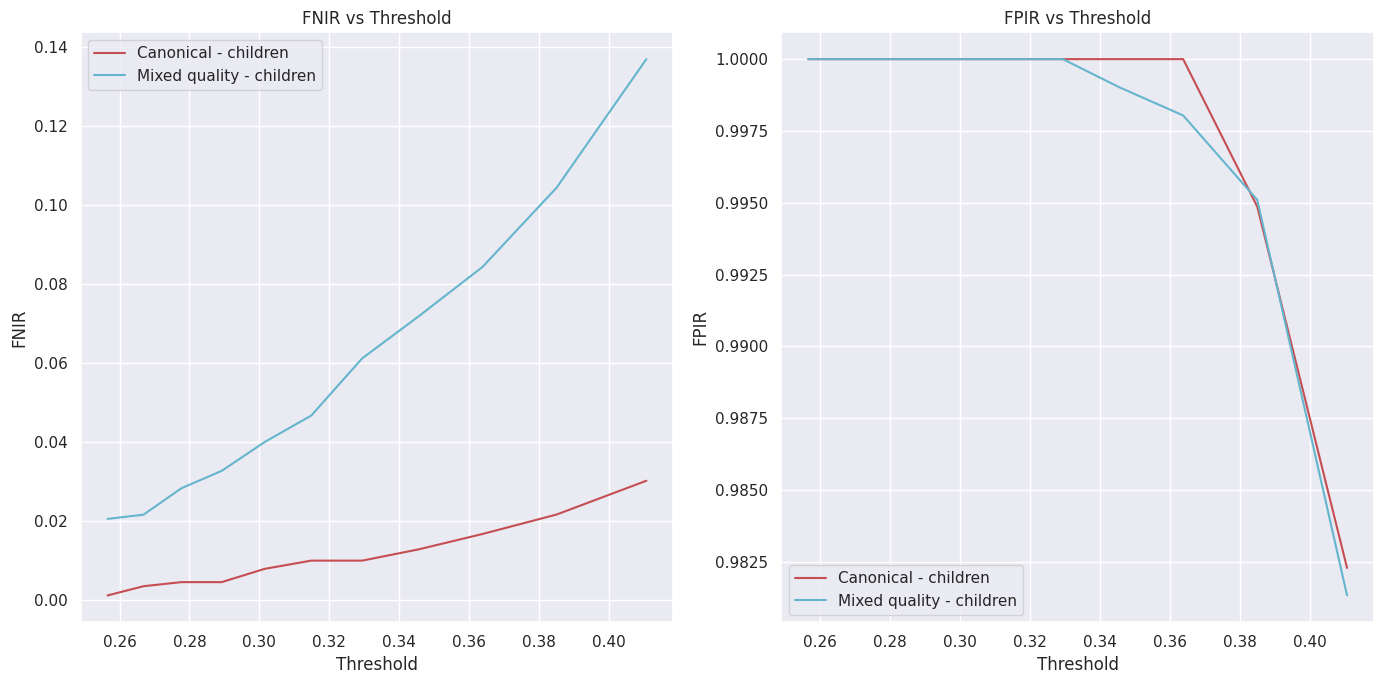

In [69]:
# Plotting FNIR and FPIR vs. Threshold
plt.figure(figsize=(14, 7))

# Plot FNIR
plt.subplot(1, 2, 1)
plt.plot(plot_df.index, plot_df['FNIR_c'], 'r-', label='Canonical - children')
plt.plot(plot_df.index, plot_df['FNIR_a'], 'c-', label='Mixed quality - children')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FNIR')
plt.title('FNIR vs Threshold')
plt.legend()

# Plot FPIR
plt.subplot(1, 2, 2)
plt.plot(plot_df.index, plot_df['FPIR_c'], 'r-', label='Canonical - children')
plt.plot(plot_df.index, plot_df['FPIR_a'], 'c-', label='Mixed quality - children')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FPIR')
plt.title('FPIR vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()


# Stats

In [73]:
df_all_results

,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,1,0.011710,0.053358,1.0,1.0,0.0,0.320039,0.240029,0.31
1,2,0.005452,0.040348,1.0,1.0,0.0,0.380967,0.285726,0.31
2,3,0.011628,0.042005,1.0,1.0,0.0,0.283196,0.212397,0.31
3,4,0.007048,0.051270,1.0,1.0,0.0,0.379150,0.284362,0.31
4,5,0.012012,0.055046,1.0,1.0,0.0,0.320871,0.240653,0.31
5,6,0.013825,0.046968,1.0,1.0,0.0,0.272589,0.204442,0.31
6,7,0.009390,0.039599,1.0,1.0,0.0,0.308332,0.231249,0.31
7,8,0.005490,0.044831,1.0,1.0,0.0,0.390896,0.293172,0.31
8,9,0.015886,0.042976,1.0,1.0,0.0,0.230119,0.172589,0.31
9,10,0.007639,0.049977,1.0,1.0,0.0,0.367410,0.275557,0.31


In [75]:
df_str = df_all_results.applymap(lambda x: f"{x:.3f}")
print(df_str)

  Iteration FNIR_c FNIR_a FPIR_c FPIR_a    FPD    FND  GARBE Threshold
0     1.000  0.012  0.053  1.000  1.000  0.000  0.320  0.240     0.310
1     2.000  0.005  0.040  1.000  1.000  0.000  0.381  0.286     0.310
2     3.000  0.012  0.042  1.000  1.000  0.000  0.283  0.212     0.310
3     4.000  0.007  0.051  1.000  1.000  0.000  0.379  0.284     0.310
4     5.000  0.012  0.055  1.000  1.000  0.000  0.321  0.241     0.310
5     6.000  0.014  0.047  1.000  1.000  0.000  0.273  0.204     0.310
6     7.000  0.009  0.040  1.000  1.000  0.000  0.308  0.231     0.310
7     8.000  0.005  0.045  1.000  1.000  0.000  0.391  0.293     0.310
8     9.000  0.016  0.043  1.000  1.000  0.000  0.230  0.173     0.310
9    10.000  0.008  0.050  1.000  1.000  0.000  0.367  0.276     0.310


/tmp/ipykernel_1171/1105259152.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_str = df_all_results.applymap(lambda x: f"{x:.3f}")


In [76]:
df_all_results.describe().applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_1171/1449581749.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,5.500,0.010,0.047,1.000,1.000,0.000,0.325,0.244,0.310
std,3.028,0.004,0.006,0.000,0.000,0.000,0.054,0.040,0.000
min,1.000,0.005,0.040,1.000,1.000,0.000,0.230,0.173,0.310
25%,3.250,0.007,0.042,1.000,1.000,0.000,0.289,0.217,0.310
50%,5.500,0.011,0.046,1.000,1.000,0.000,0.320,0.240,0.310
75%,7.750,0.012,0.051,1.000,1.000,0.000,0.376,0.282,0.310
max,10.000,0.016,0.055,1.000,1.000,0.000,0.391,0.293,0.310


# Saving sim to plot all of the dist 

In [89]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_mag_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_mag_1_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_mag_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_mag_1_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


104648
147642
14218887
32751054


In [90]:

# Loading pre-saved stuff
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_mag_1_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_mag_1_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_mag_1_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_mag_1_2.csv')).values.flatten()


# From DET utils - check import

In [77]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

# From DET utils - check import

In [91]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [92]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,147642.000000,3.275105e+07
1,Minimum,-0.032878,-3.634797e-01
2,Maximum,0.996554,9.998633e-01
3,Mean,0.622536,1.738071e-01
4,St. Dev.,0.147768,1.328158e-01
5,Skewness,-0.478645,2.500852e-01
6,Ex. Kurtosis,0.241791,1.722764e-02


In [93]:

mated_scores2 = sim_mat_c_enrolled_iterations_all

nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,104648.000000,1.421889e+07
1,Minimum,0.078514,-3.622165e-01
2,Maximum,0.996554,9.998633e-01
3,Mean,0.650505,1.806985e-01
4,St. Dev.,0.140549,1.364619e-01
5,Skewness,-0.532146,2.606570e-01
6,Ex. Kurtosis,0.235585,1.111697e-01


In [94]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [81]:
# def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
#     def normalise_scores(distribution):
#         return np.ones_like(distribution) / len(distribution)
#     plt.figure(figsize=figure_size)
#     if normalise:
#         plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
#         plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
#         xlabel = "Probability Density"
#     else:
#         plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
#         plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
#         xlabel = "Count"
#     plt.xlabel("Comparison Score", size=label_fontsize)
#     plt.ylabel(xlabel, size=label_fontsize)
#     plt.grid(True)
#     plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

#     if savename is not None:
#         plt.savefig(savename, bbox_inches="tight")
#         plt.cla()
#         plt.clf()
#         plt.close()
#     else:
#         plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)

    mated_mean = np.mean(mated_scores)

    plt.figure(figsize=figure_size)

    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
        ylabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
        ylabel = "Count"

    plt.axvline(mated_mean, color='darkred', linestyle='--', linewidth=2, label=f'Mated Mean: {mated_mean:.2f}')

    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(ylabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()


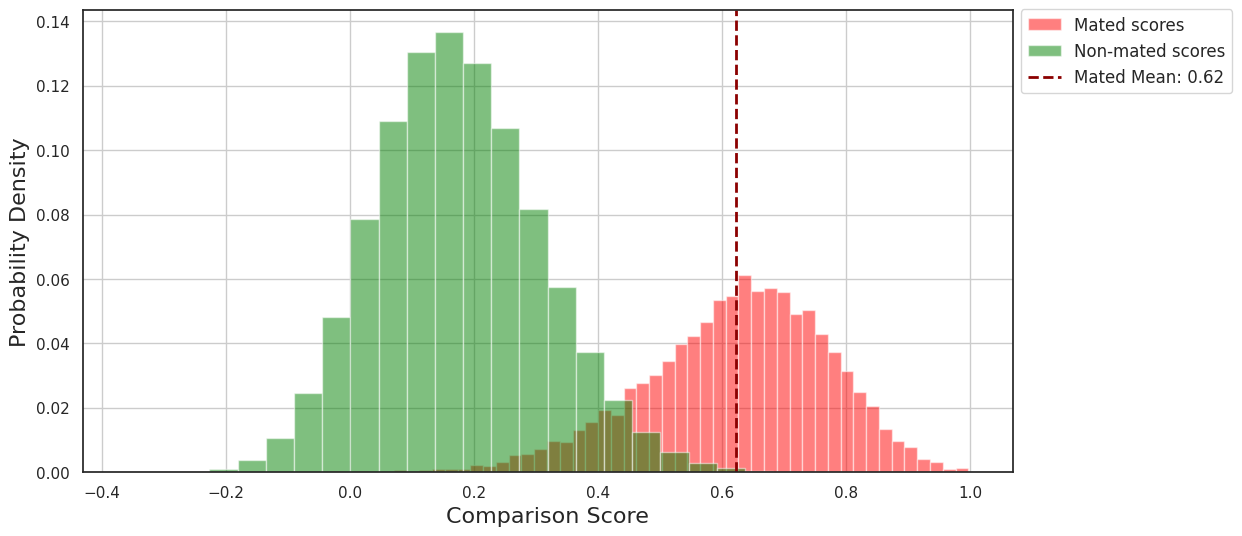

In [95]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True)


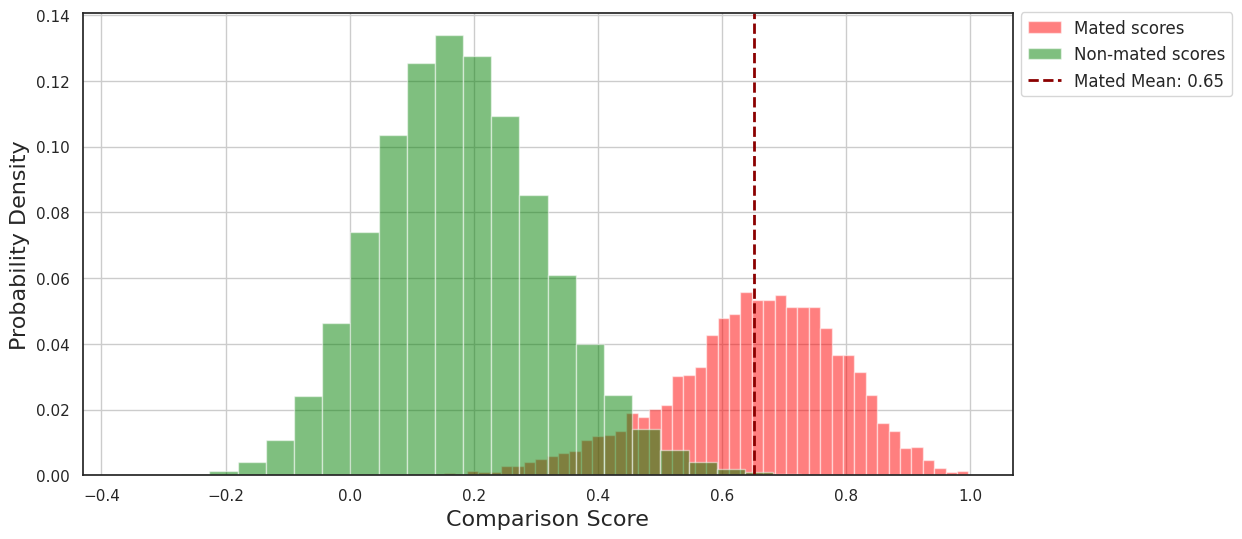

In [96]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)


# DET curves

In [99]:
from DET_utils.DET_plots import *
from DET_utils.DET import *

In [100]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)

In [101]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

# d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
# print("d' canonical =", round(d_prime_system3, round_digits))

d' child = 3.194
d' adult = 3.39161


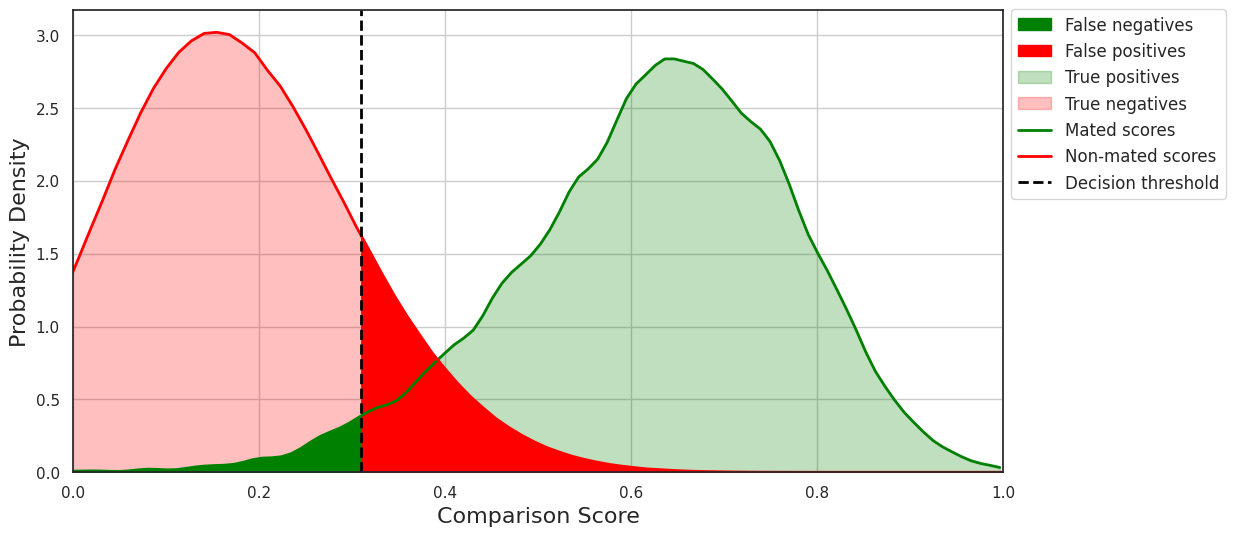

In [102]:
threshold1 = 0.31
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

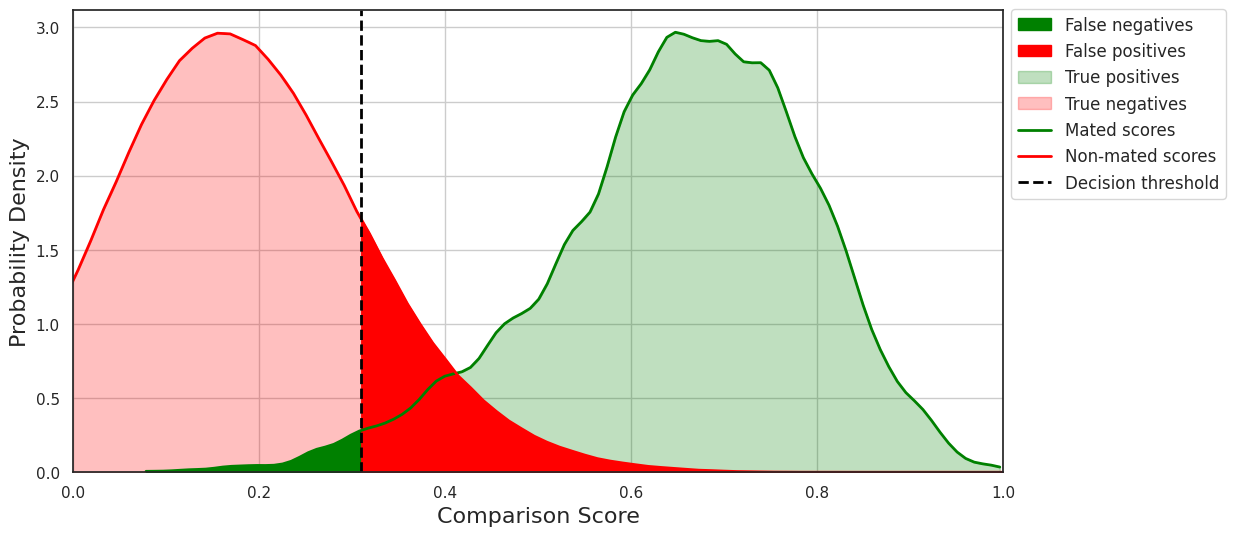

In [103]:
threshold2 = 0.31
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

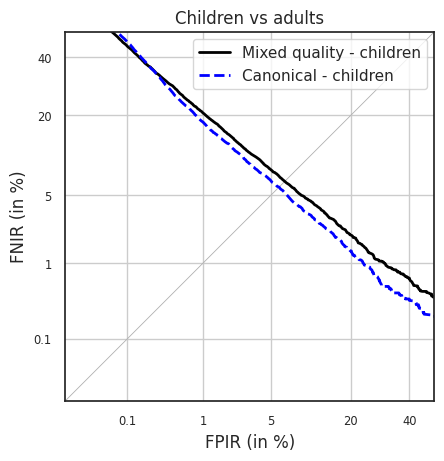

In [104]:
system_name1 = 'Mixed quality - children'
system_name2 = 'Canonical - children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()